In [ ]:
include("ct_utils.jl")
using ChargeTransport
using .CTUtils
using DataFrames
using CSV 
using PyPlot

println("Libraries imported.")

In [2]:
choices = ["dark-sc", "illuminated-sc", "illuminated-oc", "illuminated-scaps-oc", "illuminated-ct-oc"]
choice = 5

ct_filename = "../simulation_data/chargetransport/si-topcon-schottky-$(choices[choice]).csv"
scaps_filename = "../simulation_data/scaps/si-topcon-$(choices[choice]).eb"

ct_profile = ct_to_profile(ct_filename)
scaps_profile = parse_scaps(scaps_filename)

println("Data loaded successfully.")

Data loaded successfully.


## Compare Generation

In [ ]:
using PyPlot

# Define a range of x values for smooth interpolation
x_vals = range(minimum(df_gen[!, "x (um)"]), stop=maximum(df_gen[!, "x (um)"]), length=200)
G_interp = [generation_from_scaps(generation_filename, x * (μm)) * 1e-6 for x in x_vals]

figure(figsize=(8,5))
plot(x_vals, G_interp, label="Interpolated Generation", color="blue")
plot(df_gen[!, "x (um)"], df_gen[!, "Geh (#/cm3.s)"], linestyle="--", label="Raw Data", color="red")

yscale("log")
xlabel("x (um)")
ylabel("Generation Geh (#/cm³·s)")
title("Generation Profile: Interpolated vs. Raw Data")
legend()
grid(true)
display(gcf())

In [4]:
generation_from_scaps(generation_filename, 99.557 * (μm))

## Compare Densities

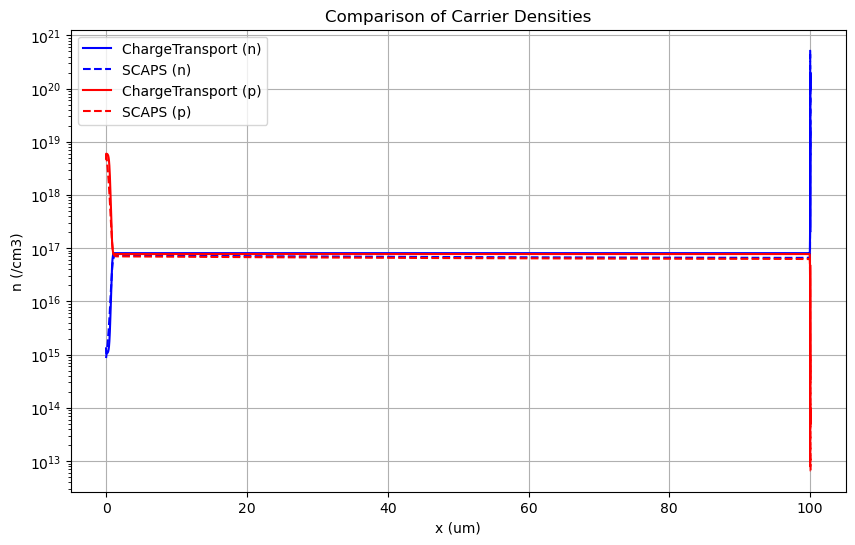

In [3]:
compare_densities(ct_filename, scaps_filename)
display(gcf())

## Compare Bands

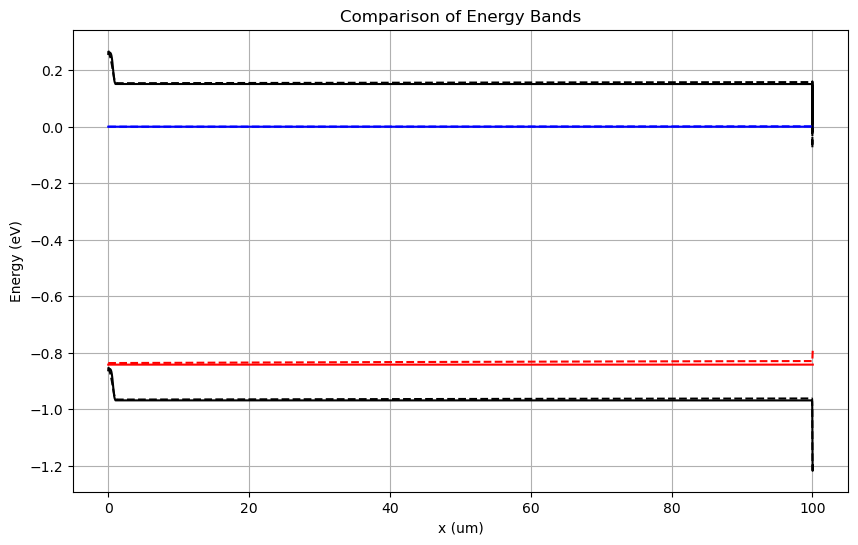

In [4]:
compare_bands(ct_profile, scaps_profile)
display(gcf())

## Compare IV Curves

In [15]:
df_ct_iv = CSV.read("../simulation_data/chargetransport/si-topcon-schottky-iv.csv", DataFrame)
df_scaps_iv = scaps_to_df_iv("../simulation_data/scaps/si-topcon.iv")

# test if it's just a horizontal translation
# df_ct_iv[!, "V"] = df_ct_iv[!, "V"] .- 0.113
df_ct_iv[!, "J"] = df_ct_iv[!, "J"] * -0.1

compare_iv(df_ct_iv, df_scaps_iv)
ylim(-100, 1000)
display(gcf())